In [1]:
%load_ext autoreload
%autoreload 2
import os
import time
import pickle
import numpy as np
import pandas as pd
import multiprocessing as mp
from IPython.display import SVG

from pydrake.geometry import MeshcatVisualizer, MeshcatVisualizerParams, Role, StartMeshcat
from pydrake.geometry.optimization import IrisInConfigurationSpace, IrisOptions
from pydrake.multibody.parsing import LoadModelDirectives, Parser, ProcessModelDirectives
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.solvers import MosekSolver
from pydrake.systems.framework import DiagramBuilder

from gcs.linear import LinearGCS
from gcs.rounding import randomForwardPathSearch
from reproduction.prm_comparison.planning import PresplinedPRM
from pydrake.all import (PRMPlannerCreationParameters, BiRRTPlannerParameters, PRMPlannerCreationParameters, PRMPlannerQueryParameters, PathProcessorParameters)
from reproduction.prm_comparison.helpers import (
    get_traj_length,
    InverseKinematics,
    make_traj,
    visualize_trajectory,
    plot_results,
    make_result_table,
)

from pydrake.all import PRMPlanner,BiRRTPlanner
from itertools import combinations

from pydrake.all import ChangeOmpNumThreadsWrapper

from reproduction.util import GcsDir, FindModelFile

mosek_license = MosekSolver.AcquireLicense()

In [2]:
# Start the visualizer (run this cell only once, each instanc|e consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [13]:
SEED = 0
np.random.seed(SEED)
# CORE_CNT = mp.cpu_count() # you may edit this.
CORE_CNT = 15

In [4]:
meshcat.Delete()
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
parser = Parser(plant)
parser.package_map().Add("gcs", GcsDir())

directives_file = FindModelFile("models/iiwa14_welded_gripper.yaml")
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)
[iiwa, wsg, shelf, binR, binL, table] = models
iiwa_idx = plant.GetModelInstanceByName("iiwa")
wsg_idx = plant.GetModelInstanceByName("wsg")

plant.Finalize()

meshcat_params = MeshcatVisualizerParams()
meshcat_params.delete_on_initialization_event = False
meshcat_params.role = Role.kIllustration
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat,
                                             meshcat_params)

diagram = builder.Build()

context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = [0, 0.3, 0, -1.8, 0, 1, 1.57]
plant.SetPositions(plant_context, q0)
diagram.ForcedPublish(context)

## IRIS Seeds

In [5]:
milestones = {
    "AS": [[0.75, 0, 0.9], [0, -np.pi, -np.pi / 2]],
    "TS": [[0.75, 0, 0.67], [0, -np.pi, -np.pi / 2]],
    "CS": [[0.75, 0, 0.41], [0, -np.pi, -np.pi / 2]],
    "LB": [[0.0, 0.6, 0.22], [np.pi / 2, np.pi, 0]],
    "RB": [[0.0, -0.6, 0.22], [np.pi / 2, np.pi, np.pi]]
}

additional_seed_points = {
    "C": np.array([0, 0.2, 0, -2.09, 0, -0.3, np.pi / 2]),
    "L": np.array([0.8, 0.7, 0, -1.6, 0, 0, np.pi / 2]),
    "R": np.array([-0.8, 0.7, 0, -1.6, 0, 0, np.pi / 2])
}

q0 = [0, 0.3, 0, -1.8, 0, 1, 1.57]
milestone_configurations = {
    name: InverseKinematics(q0, trans, rot)
    for name, (trans, rot) in milestones.items()
}

seed_points = {**milestone_configurations, **additional_seed_points}

# Load pre-generated regions

In [6]:
#load regions
with open(os.path.join(GcsDir(), "data/prm_comparison/IRIS.reg"), "rb") as f:
    regions = pickle.load(f)

# Or Regenerate IRIS Regions

Note: This IRIS region computation is slow. We give the option to load the pre-generated regions in the cells below; in which case you can skip this step.

## via manual seeds

In [ ]:
iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 10
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.02
iris_options.num_collision_infeasible_samples = 1
iris_options.random_seed = SEED


In [ ]:
def calcRegion(seed, verbose):
    start_time = time.time()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    plant.SetPositions(plant_context, seed)
    try:
        hpoly = IrisInConfigurationSpace(plant, plant_context, iris_options)
    except Exception as e:
        print(f"Seed: {seed} failed with error: {e}")
        return None
    if verbose:
        print("Seed:", seed, "\tTime:", time.time() - start_time, flush=True)
    return hpoly


def generateRegions(seed_points, verbose=True):
    seeds = list(
        seed_points.values()) if type(seed_points) is dict else seed_points
    regions = []
    loop_time = time.time()
    with mp.Pool(processes=min(CORE_CNT, len(seed_points))) as pool:
        regions = pool.starmap(calcRegion, [[seed, verbose] for seed in seeds])

    if verbose:
        print("Loop time:", time.time() - loop_time)

    if type(seed_points) is dict:
        return dict(list(zip(seed_points.keys(), regions)))

    return regions

In [ ]:
regions = generateRegions(seed_points)

# Create the GCS Trajectory Optimization

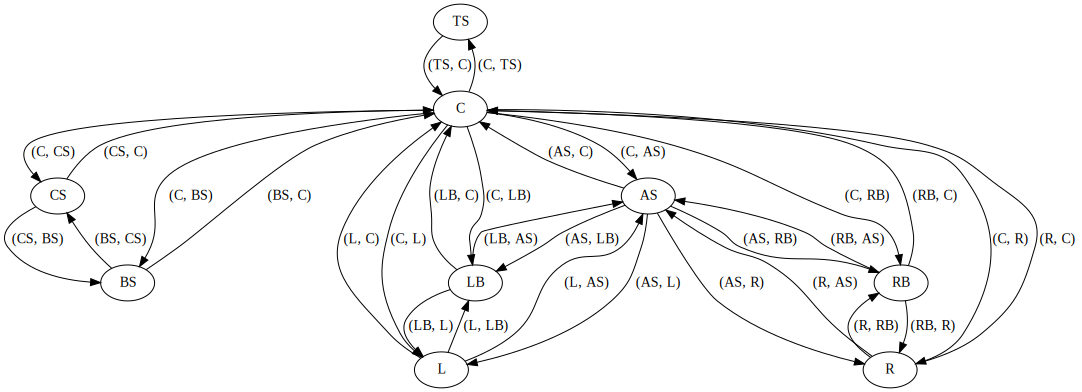

In [7]:
gcs = LinearGCS(regions)
SVG(gcs.VisualizeGraph()) 

# PRM

In [ ]:
prm_parameters = PRMPlannerCreationParameters()
prm_parameters.roadmap_size = 10000 
prm_parameters.num_neighbors = 5
prm_parameters.max_valid_sample_tries = 100
prm_parameters.parallelize = True 

birrt_parameters = BiRRTPlannerParameters()
birrt_parameters.tree_sampling_bias = 0.5
birrt_parameters.p_switch_trees = 0.25
birrt_parameters.time_limit = 120.0
birrt_parameters.connection_tolerance = 1e-5
birrt_parameters.prng_seed = SEED
birrt_parameters.parallelize_nearest_neighbor = True

query_parameters = PRMPlannerQueryParameters()
query_parameters.num_neighbors = 5
query_parameters.parallelize = True

postprocessing_parameters = PathProcessorParameters()
postprocessing_parameters.max_smoothing_shortcut_fraction = 1.0
postprocessing_parameters.resampled_state_interval = 0.2
postprocessing_parameters.prng_seed = SEED
postprocessing_parameters.max_smoothing_iterations = 200
postprocessing_parameters.max_failed_smoothing_iterations = 200
postprocessing_parameters.max_backtracking_steps = 0
postprocessing_parameters.use_shortcut_smoothing = True
postprocessing_parameters.resample_before_smoothing = True

In [ ]:
ChangeOmpNumThreadsWrapper(int(0.95*CORE_CNT)) # We saw Thrashing with 100% CPU usage.

In [ ]:
prm = PresplinedPRM(edge_step_size = 0.05,
                    env_padding = 0.00,
                    self_padding = 0.00,
                    propagation_step_size = 0.5,
                    grid_size = [1.8, 2.4, 1.6],
                    grid_resolution=0.04,
                    seed = SEED)

## Load Roadmap

In [ ]:
prm.load(GcsDir() + "/data/prm_comparison/roadmap.rmp")

## Or Generate PRM

In [ ]:
ChangeOmpNumThreadsWrapper(1) # Running BiRRT on a single thread is much faster.

In [ ]:
# BiRRT connect.
splined_path = []
birrt_times = []
for start, goal in combinations(seed_points.values(), 2):
    # BiRRT connect.
    result, runtime = BiRRTPlanner.TimedPlan(
        start,
        goal,
        birrt_parameters,
        prm.planning_space,
    )
    birrt_times.append(runtime)
    if result.has_solution():
        splined_path += result.path()
print(f'Spline number of nodes: {len(splined_path)}')
print(
    f"Birrt time: {round(sum(birrt_times), 3)} seconds, {round(max(birrt_times), 3)} seconds max"
)


In [ ]:
ChangeOmpNumThreadsWrapper(int(0.95*CORE_CNT)) # We saw Thrashing with 100% CPU usage.

In [ ]:
splined_path = np.vstack(splined_path)
prm.roadmap, prm_runtime = PRMPlanner.TimedBuildRoadmap(
    prm_parameters, splined_path, prm.planning_space)
print(f"PRM run time: {round(prm_runtime, 3)} seconds")

# Run Comparison

In [18]:
solver_tolerance = 1e-6


def getGCSPath(sequence, verbose=False):
    path = [sequence[0]]
    run_time = 0.0
    for start_pt, goal_pt in zip(sequence[:-1], sequence[1:]):
        gcs = LinearGCS(regions)
        gcs.addSourceTarget(start_pt, goal_pt)
        gcs.setRoundingStrategy(randomForwardPathSearch,
                                max_paths=10,
                                max_trials=100,
                                seed=SEED)
        gcs.setSolver(MosekSolver())
        # gcs.options.solver_options.SetOption(MosekSolver.id(),
        #                                      'MSK_DPAR_INTPNT_TOL_PFEAS',
        #                                      solver_tolerance)
        # gcs.options.solver_options.SetOption(MosekSolver.id(),
        #                                      'MSK_DPAR_INTPNT_TOL_DFEAS',
        #                                      solver_tolerance)
        # gcs.options.solver_options.SetOption(MosekSolver.id(),
        #                                      'MSK_DPAR_INTPNT_TOL_REL_GAP',
        #                                      solver_tolerance)
        # gcs.options.solver_options.SetOption(MosekSolver.id(),
        #                                      'MSK_DPAR_INTPNT_TOL_INFEAS',
        #                                      solver_tolerance)
        waypoints, results_dict = gcs.SolvePath(rounding=True,
                                                verbose=False,
                                                preprocessing=True)
        if waypoints is None:
            if verbose:
                print(f"Failed between {start_pt} and {goal_pt}")
            return None

        run_time += results_dict["relaxation_solver_time"]
        run_time += results_dict[
            "max_rounded_solver_time"]  # only take the max since rounding can be parallelized
        if verbose:
            print(
                "Convex Relaxation", round(results_dict["relaxation_cost"],
                                           3), "min hard result cost",
                round(results_dict["rounded_cost"], 3), "Gap",
                round((results_dict["rounded_cost"] -
                       results_dict["relaxation_cost"]) /
                      results_dict["relaxation_cost"], 3))

        path += waypoints.T[1:].tolist()
    return np.stack(path).T, run_time

## Demonstration

In [9]:
demonstration = {
    "AS": [[0.75, -0.12, 0.9], [0, -np.pi, -np.pi / 2]],
    "TS": [[0.75, 0.12, 0.67], [0, -np.pi, -np.pi / 2]],
    "CS": [[0.75, 0.12, 0.41], [0, -np.pi, -np.pi / 2]],
    "LB": [[0.08, 0.6, 0.22], [np.pi / 2, np.pi, 0]],
    "RB": [[-0.08, -0.6, 0.22], [np.pi / 2, np.pi, np.pi]]
}

q0 = [0, 0.3, 0, -1.8, 0, 1, 1.57]
demonstration_configurations = {
    name: InverseKinematics(q0, trans, rot)
    for name, (trans, rot) in demonstration.items()
}

In [10]:
task_1 = [demonstration_configurations["AS"],
          demonstration_configurations["TS"]]

task_2 = [demonstration_configurations["TS"],
          demonstration_configurations["CS"]]

task_3 = [demonstration_configurations["CS"],
          demonstration_configurations["LB"]]

task_4 = [demonstration_configurations["LB"],
          demonstration_configurations["RB"]]

task_5 = [demonstration_configurations["RB"],
          demonstration_configurations["AS"]]

task_circle = [demonstration_configurations["AS"],
               demonstration_configurations["TS"],
               demonstration_configurations["CS"],
               demonstration_configurations["LB"],
               demonstration_configurations["RB"],
               demonstration_configurations["AS"]]

In [19]:
execute_task = task_circle
for excute_task in [task_1,task_2,task_3,task_4,task_5]:

    GCS_path, GCS_time = getGCSPath(execute_task, verbose=True)
    linear_gcs_traj = make_traj(GCS_path, speed=2)
    print(
        f"Linear GCS length: {round(get_traj_length(linear_gcs_traj), 3)}, and time: {round(GCS_time, 3)} s"
)

# PRM_path, PRM_time = prm.plan(execute_task, query_parameters)
# prm_traj = make_traj(PRM_path, speed=2)
# print(
#     f"PRM length: {round(get_traj_length(prm_traj), 3)}, and time: {round(PRM_time, 3)} s"
# )

# sPRM_path, sPRM_time = prm.plan(execute_task, query_parameters,
#                                 postprocessing_parameters)
# sprm_traj = make_traj(sPRM_path, speed=2)
# print(
#     f"Smoothed PRM length: {round(get_traj_length(sprm_traj), 3)}, and time: {round(sPRM_time, 3)} s"
# )


Convex Relaxation 2.759 min hard result cost 3.254 Gap 0.179
Convex Relaxation 2.103 min hard result cost 2.103 Gap -0.0
Convex Relaxation 2.624 min hard result cost 2.624 Gap -0.0
Convex Relaxation 3.337 min hard result cost 3.485 Gap 0.044
Convex Relaxation 1.804 min hard result cost 1.805 Gap 0.0
Linear GCS length: 13.27, and time: 0.116 s
Convex Relaxation 2.759 min hard result cost 3.254 Gap 0.179
Convex Relaxation 2.103 min hard result cost 2.103 Gap -0.0
Convex Relaxation 2.624 min hard result cost 2.624 Gap -0.0
Convex Relaxation 3.337 min hard result cost 3.485 Gap 0.044
Convex Relaxation 1.804 min hard result cost 1.805 Gap 0.0
Linear GCS length: 13.27, and time: 0.116 s
Convex Relaxation 2.759 min hard result cost 3.254 Gap 0.179
Convex Relaxation 2.103 min hard result cost 2.103 Gap -0.0
Convex Relaxation 2.624 min hard result cost 2.624 Gap -0.0
Convex Relaxation 3.337 min hard result cost 3.485 Gap 0.044
Convex Relaxation 1.804 min hard result cost 1.805 Gap 0.0
Linear GC

In [ ]:
visualize_trajectory(meshcat, [linear_gcs_traj, prm_traj, sprm_traj],
                     show_path=True,
                     robot_configurations=execute_task,
                     transparency=0.3)


In [ ]:
with open ("GCS_PRM10k_comparison.html", "w") as f:
    f.write(meshcat.StaticHtml())

## Comparison Table for Paper


In [ ]:
ChangeOmpNumThreadsWrapper(1)

In [ ]:
tasks_for_paper = {
    "AS->TS": task_1,
    "TS->CS": task_2,
    "BS->LB": task_3,
    "LB->RB": task_4,
    "RB->TS": task_5
}

gcs_data = {
    task: {
        "Path Length (rad)": [],
        "Time (ms)": []
    }
    for task, _ in tasks_for_paper.items()
}
prm_data = {
    task: {
        "Path Length (rad)": [],
        "Time (ms)": []
    }
    for task, _ in tasks_for_paper.items()
}
sprm_data = {
    task: {
        "Path Length (rad)": [],
        "Time (ms)": []
    }
    for task, _ in tasks_for_paper.items()
}

N = 5  # We ran this 100 in the paper
for _ in range(N):
    for task_name, task in tasks_for_paper.items():
        traj, runtime = getGCSPath(task)[:2]
        traj_len = get_traj_length(make_traj(traj))
        gcs_data[task_name]["Path Length (rad)"].append(traj_len)
        gcs_data[task_name]["Time (ms)"].append(runtime * 1000)

        traj, runtime = prm.plan(task, query_parameters)
        traj_len = get_traj_length(make_traj(traj))
        prm_data[task_name]["Path Length (rad)"].append(traj_len)
        prm_data[task_name]["Time (ms)"].append(runtime * 1000)

        traj, runtime = prm.plan(task, query_parameters,
                                 postprocessing_parameters)
        traj_len = get_traj_length(make_traj(traj))
        sprm_data[task_name]["Path Length (rad)"].append(traj_len)
        sprm_data[task_name]["Time (ms)"].append(runtime * 1000)


In [ ]:
plot_results(gcs_data, prm_data, sprm_data)

In [ ]:
make_result_table(gcs_data, prm_data, sprm_data).round(2)

## Random Configurations

In [ ]:
def sample_demonstration_configurations():
    shelve_y_bounds = (-0.12, 0.12)
    shelve_x_bounds = (-0.02, 0.02)
    shelve_z_bounds = (-0.01, 0.01)

    bin_x_bounds = (0.08, -0.08)
    bin_y_bounds = (0.02, -0.02)
    bin_z_bounds = (0.01, -0.01)

    random_demo = {
        "AS": [[
            0.75 + np.random.uniform(*shelve_x_bounds),
            np.random.uniform(*shelve_y_bounds),
            0.9 + np.random.uniform(*shelve_z_bounds)
        ], [0, -np.pi, -np.pi / 2]],
        "TS": [[
            0.75 + np.random.uniform(*shelve_x_bounds),
            np.random.uniform(*shelve_y_bounds),
            0.67 + np.random.uniform(*shelve_z_bounds)
        ], [0, -np.pi, -np.pi / 2]],
        "CS": [[
            0.75 + np.random.uniform(*shelve_x_bounds),
            np.random.uniform(*shelve_y_bounds),
            0.41 + np.random.uniform(*shelve_z_bounds)
        ], [0, -np.pi, -np.pi / 2]],
        "LB": [[
            np.random.uniform(*bin_x_bounds),
            0.6 + np.random.uniform(*bin_y_bounds),
            0.22 + np.random.uniform(*bin_z_bounds)
        ], [np.pi / 2, np.pi, 0]],
        "RB": [[
            np.random.uniform(*bin_x_bounds),
            -0.6 + np.random.uniform(*bin_y_bounds),
            0.22 + np.random.uniform(*bin_z_bounds)
        ], [np.pi / 2, np.pi, np.pi]]
    }
    q0 = [0, 0.3, 0, -1.8, 0, 1, 1.57]
    return {
        name: InverseKinematics(q0, trans, rot)
        for name, (trans, rot) in random_demo.items()
    }

In [ ]:
random_gcs_data = {
    task: {
        "Path Length (rad)": [],
        "Time (ms)": []
    }
    for task, _ in tasks_for_paper.items()
}
random_prm_data = {
    task: {
        "Path Length (rad)": [],
        "Time (ms)": []
    }
    for task, _ in tasks_for_paper.items()
}
random_sprm_data = {
    task: {
        "Path Length (rad)": [],
        "Time (ms)": []
    }
    for task, _ in tasks_for_paper.items()
}

N = 1000
gcs_failed = 0
prm_failed = 0
sprm_failed = 0
for _ in range(N):
    random_configuration = sample_demonstration_configurations()
    random_task_1 = [random_configuration["AS"], random_configuration["TS"]]

    random_task_2 = [random_configuration["TS"], random_configuration["CS"]]

    random_task_3 = [random_configuration["CS"], random_configuration["LB"]]

    random_task_4 = [random_configuration["LB"], random_configuration["RB"]]

    random_task_5 = [random_configuration["RB"], random_configuration["AS"]]

    random_tasks = {
        "AS->TS": random_task_1,
        "TS->CS": random_task_2,
        "BS->LB": random_task_3,
        "LB->RB": random_task_4,
        "RB->TS": random_task_5
    }

    for task_name, task in random_tasks.items():
        try:
            traj, runtime = getGCSPath(task)[:2]
            traj_len = get_traj_length(make_traj(traj))
            random_gcs_data[task_name]["Path Length (rad)"].append(traj_len)
            random_gcs_data[task_name]["Time (ms)"].append(runtime * 1000)
        except:
            gcs_failed += 1

        try:
            traj, runtime = prm.plan(task, query_parameters)
            traj_len = get_traj_length(make_traj(traj))
            random_prm_data[task_name]["Path Length (rad)"].append(traj_len)
            random_prm_data[task_name]["Time (ms)"].append(runtime * 1000)
        except:
            prm_failed += 1

        try:
            traj, runtime = prm.plan(task, query_parameters,
                                     postprocessing_parameters)
            traj_len = get_traj_length(make_traj(traj))
            random_sprm_data[task_name]["Path Length (rad)"].append(traj_len)
            random_sprm_data[task_name]["Time (ms)"].append(runtime * 1000)
        except:
            sprm_failed += 1


In [ ]:
print(f"GCS failed {gcs_failed} times")
print(f"PRM failed {prm_failed} times")
print(f"SPRM failed {sprm_failed} times")

In [ ]:
plot_results(random_gcs_data, random_prm_data, random_sprm_data)

In [ ]:
with open('random_sprm_data', 'wb') as f:
    pickle.dump(random_sprm_data, f)

In [ ]:
make_result_table(random_gcs_data, random_prm_data, random_sprm_data)

## Debug
When playing with the demonstration points, use this to understand where PRM fails and where the regions to include the configurations

In [ ]:
for k,v in {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in demonstration.items()}.items():
    print(k, regions[k].PointInSet(v), not prm.getPath([q0, v]) is None)

In [ ]:
execute_task = task_1
GCS_path, GCS_time, relaxed_results = getGCSPath(execute_task, verbose = True)

def extractEdgeFlows(gcs):
    return {e.name(): gcs.relaxed_result.GetSolution(e.phi()) for e in gcs.gcs.Edges()}
gcs = LinearGCS(regions.copy())
gcs.addSourceTarget(execute_task[0], execute_task[1])
gcs.setRoundingStrategy(randomForwardPathSearch, max_paths = 10, max_trials = 100, seed = SEED)
gcs.setSolver(MosekSolver())
start_time = time.time()
waypoints, results_dict = gcs.SolvePath(rounding=True, verbose=False, preprocessing=True)
task = extractEdgeFlows(gcs)

task = {(k.split(', ')[0][1:],k.split(', ')[1][:-1]): v  for k,v in task.items()}
task = {k: v for k,v in task.items() if not 'source' in k and not 'target' in k}
task